In [1]:
import random
from typing import TypedDict, List, Annotated
import operator
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

**Data Processing (Sequential)** 

In [2]:
class State(TypedDict):
    input: int
    output: int

In [3]:
def node_a(state: State):
    input_value = state['input']
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE A:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": output}

def node_b(state: State):
    input_value = state['output'] # Coming from output
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE B:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": output}


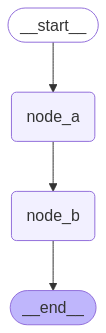

In [4]:
workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)
graph = workflow.compile()
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [8]:
graph.invoke(
    input = {
        "input": 1,
    }, 
)

NODE A:
 ->input:1
 ->offset:6
 ->output:7
 
NODE B:
 ->input:7
 ->offset:3
 ->output:10
 


{'input': 1, 'output': 10}

**Data Processing (Parallel)**

In [9]:
class State(TypedDict):
    input: int
    output: int

In [10]:
def node_a(state: State):
    input_value = state['input']
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE A:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": output}

def node_b(state: State):
    input_value = state['input'] # Coming from input
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE B:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": output}


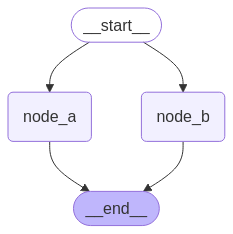

In [11]:
workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge(START, "node_b")
workflow.add_edge("node_a", END)
workflow.add_edge("node_b", END)
graph = workflow.compile()
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [12]:
graph.invoke(
    input = {
        "input": 1,
    }, 
)

NODE A:
 ->input:1
 ->offset:6
 ->output:7
 NODE B:
 ->input:1
 ->offset:7
 ->output:8
 



InvalidUpdateError: At key 'output': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

**Data Processing with a Reducer**

In [13]:
help(operator.add)

Help on built-in function add in module _operator:

add(a, b, /)
    Same as a + b.



In [14]:
operator.add([1,2,3],[4,5,6])

[1, 2, 3, 4, 5, 6]

In [15]:
class State(TypedDict):
    input: int
    output: Annotated[List[int], operator.add]

In [16]:
def node_a(state: State):
    input_value = state['input']
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE A:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": [output]} # now it's a List of ints

def node_b(state: State):
    input_value = state['input'] # Coming from input
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE B:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": [output]} # now it's a List of ints


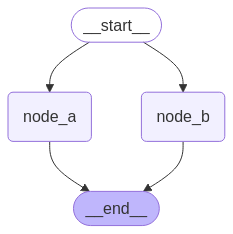

In [17]:
workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge(START, "node_b")
workflow.add_edge("node_a", END)
workflow.add_edge("node_b", END)
graph = workflow.compile()
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [18]:
graph.invoke(
    input = {
        "input": 1,
    }, 
)

NODE A:
 ->input:1
 ->offset:8
 ->output:9
 
NODE B:
 ->input:1
 ->offset:3
 ->output:4
 


{'input': 1, 'output': [9, 4]}

**Call LLMs with Custom State and Langgraph operator**

In [19]:
operator.add(
    [
        SystemMessage("You're a helpful assistant"),
        HumanMessage("Hi!")
    ],
    [
        AIMessage("Hello! How can I assist you today?")
    ]
)

[SystemMessage(content="You're a helpful assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={})]

In [20]:
operator.add(
    [
        SystemMessage("You're a helpful assistant"),
        HumanMessage("Hi!")
    ],
    AIMessage("Hello! How can I assist you today?")
)

TypeError: can only concatenate list (not "AIMessage") to list

In [21]:
help(add_messages)

Help on function _add_messages in module langgraph.graph.message:

_add_messages(left: Union[list[Union[langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any]]], langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any], NoneType] = None, right: Union[list[Union[langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any]]], langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any], NoneType] = None, **kwargs: Any) -> Union[list[Union[langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any]]], langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any], Callable[[Union[list[Union[langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any]]], langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any]], Union[list[Union[langchain_core.messa

In [22]:
add_messages(
    left = [
        SystemMessage("You're a helpful assistant"),
        HumanMessage("Hi!")
    ],
    right = AIMessage("Hello! How can I assist you today?")
)

[SystemMessage(content="You're a helpful assistant", additional_kwargs={}, response_metadata={}, id='5f0491c4-7777-47e3-9b5e-fabc236f9997'),
 HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='1dd5ff55-8351-482b-868e-5aa2ee66a80a'),
 AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='c5988223-0aa9-4504-873c-08eb5c4109da')]

In [23]:
class State(TypedDict):
    messages:Annotated[List[AnyMessage], add_messages]

In [24]:
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [25]:
def model(state: State):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": response}

In [26]:
workflow = StateGraph(State)
workflow.add_node("model", model)
workflow.add_edge(START, "model")
workflow.add_edge("model", END)
graph = workflow.compile()

In [27]:
result = graph.invoke(
    input={
        "messages": [HumanMessage("What's the name of Ash's first pokémon?")]}, 
)

In [28]:
for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================

What's the name of Ash's first pokémon?
================================== Ai Message ==================================

Ash's first Pokémon is Pikachu. He received Pikachu from Professor Oak at the beginning of his journey in the Pokémon anime series.


**Call LLMs with Langgraph MessagesState**

In [29]:
def model(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": response}

In [30]:
workflow = StateGraph(MessagesState)
workflow.add_node("model", model)
workflow.add_edge(START, "model")
workflow.add_edge("model", END)
graph = workflow.compile()

In [31]:
result = graph.invoke(
    input={
        "messages": [HumanMessage("What's the name of Ash's first pokémon?")]}, 
)

In [32]:
for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================

What's the name of Ash's first pokémon?
================================== Ai Message ==================================

Ash's first Pokémon is Pikachu. He received Pikachu from Professor Oak at the beginning of his journey in the Pokémon anime series.
